### MLP's in Pytorch

In [46]:
import time
import numpy as np
from glob import glob
from os import listdir, walk
from os.path import isfile, join
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim

In [12]:
%matplotlib inline

In [13]:
is_cuda=False
if torch.cuda.is_available():
    is_cuda = True
is_cuda

True

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [35]:
transfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

In [36]:
train_dataset = datasets.MNIST('../data/',train=True, transform=transfms, download=True)
test_dataset = datasets.MNIST('../data/',train=False, transform=transfms, download=True)


In [37]:
# model parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.01
image_h = 28
image_w = 28

In [38]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, shuffle=False)

In [39]:
# linear
class MLPNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(MLPNet, self).__init__()
        self.fc1= nn.Linear(image_h*image_w, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = x.view(-1, image_h*image_w)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [40]:
model = MLPNet()


In [41]:
if is_cuda:
    model = model.to(device)

In [42]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [57]:
criterion = nn.CrossEntropyLoss()


### Train

In [52]:
def fit(epoch, model, data_loader, phase='train', volatile=False):
    if phase == 'train':
        model.train()
    if phase == 'val':
        #just sets evaluation mode - doesnt actually 'evaluate' anything
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    ave_loss = 0
    for batch_idx, (x, target) in enumerate(data_loader):
        if is_cuda:
            x, target = x.to(device), target.to(device)
        x, target = Variable(x, volatile), Variable(target)
        if phase == 'training':
            #as backward() accumulates gradients, we  zero them at the start of a new minibatch. 
            optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, target)
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        running_loss += loss.item()
        preds = output.data.max(dim=1, keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'train':
            loss.backward()
            optimizer.step()
        if (batch_idx+1)%100 == 0 or (batch_idx+1)==len(data_loader):
            print(f'epoch: {epoch}, batch: {batch_idx}, av train loss: {ave_loss}, running loss: {running_loss}')
            
    loss = float(running_loss/len(data_loader.dataset))
    accuracy = float(100. * running_correct/len(data_loader.dataset))
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy
        

In [53]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(num_epochs):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

epoch: 0, batch: 99, av train loss: 2.306326131694163, running loss: 230.5118932723999
epoch: 0, batch: 199, av train loss: 2.3052996009546427, running loss: 461.04135751724243
epoch: 0, batch: 299, av train loss: 2.302629729484613, running loss: 691.5872256755829
epoch: 0, batch: 399, av train loss: 2.3055428944213046, running loss: 922.1644637584686
epoch: 0, batch: 499, av train loss: 2.305714152106776, running loss: 1152.6668717861176
epoch: 0, batch: 599, av train loss: 2.3042987052748662, running loss: 1383.190022468567
training loss is 0.023 and training accuracy is 5137/60000       8.0
epoch: 0, batch: 99, av train loss: 2.3054503432933875, running loss: 230.530930519104
validation loss is 0.023 and validation accuracy is 868/10000       8.0
epoch: 1, batch: 99, av train loss: 2.3042708353671513, running loss: 230.53728652000427
epoch: 1, batch: 199, av train loss: 2.3044478046912884, running loss: 461.09615993499756
epoch: 1, batch: 299, av train loss: 2.305852918771943, runni

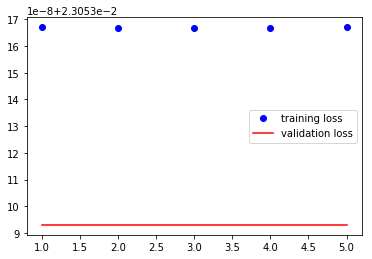

In [55]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()